In [1]:
import os
import datetime
import io
from urllib.request import urlopen, Request
import sqlite3
import pickle

import metpy.calc
from metpy.units import units 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import pandas as pd 

from synoptic.plots import map_metadata
import synoptic.services as ss
%matplotlib inline

# data_root = "./local_data"
# if not os.path.exists(data_root):
#     os.makedirs(data_root)
# obs_fpath = os.path.join(".", data_root, "basin_obs.h5")
# metadata_fpath = os.path.join(".", data_root, "basin_ob_metadata.h5")
# 
# force_do = False

/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
def get_closest_non_nan(df, column, target_time, tolerance):
    # Find the closest index to the target time within the tolerance

    # If whole column is nan, just return None
    # print(df[column])
    is_all_nan = df[column].isna().all()
    # print(is_all_nan)
    if is_all_nan:
        return np.nan

    closest_time = df.index.get_indexer([target_time], method='nearest')[0]
    time_diff = abs(df.index[closest_time] - target_time)

    # Check if within tolerance and non-NaN
    if time_diff <= pd.Timedelta(tolerance) and not pd.isna(df.at[df.index[closest_time], column]):
        return df.at[df.index[closest_time], column]

    # Search backwards and forwards for the closest non-NaN value within tolerance
    for i in range(1, tolerance.total_seconds() // df.index.freq.delta.total_seconds() + 1):
        for time_shift in [-i, i]:
            new_time = df.index[closest_time] + pd.Timedelta(seconds=time_shift * df.index.freq.delta.total_seconds())
            if new_time in df.index:
                if abs(new_time - target_time) <= pd.Timedelta(tolerance) and not pd.isna(df.at[new_time, column]):
                    return df.at[new_time, column]

    return np.nan  # Return None if no value found within tolerance

In [3]:
def get_profile_df(dt,df,elevs,stids,temp_type="drybulb"):
    profile_data = []
    for elev,stid in zip(elevs,stids):
        print(stid)
        # Time window is just for memory convenience - tolerance is set later
        sub_df = df[
                    (df['stid'] == stid) &
                    (df.index <= dt + pd.Timedelta(minutes=30)) &
                    (df.index >= dt - pd.Timedelta(minutes=30))
                    ]
        
        # print(sub_df["air_temp"])
        
        # i = sub_df.index.get_indexer([prof_dt,],method='nearest')
        # print(i)
        if len(sub_df) == 0:
            print("no measurement in this range.") 
            continue
            
            
        # temp = sub_df["air_temp"].iloc[i]
        temp = get_closest_non_nan(sub_df, "air_temp", dt, pd.Timedelta('30 minutes'))
        print(temp)
        
        elev = get_closest_non_nan(sub_df, "elevation", dt, pd.Timedelta('30 minutes'))
        print(elev)
        
        if temp_type == "drybulb":
            if (not np.isnan(temp)) and (not np.isnan(elev)):
                profile_data.append([elev,temp])
                
        elif temp_type == "theta":
            # p = sub_df["pressure"].iloc[i]
            p = get_closest_non_nan(sub_df, "pressure", dt, pd.Timedelta('30 minutes'))
            
            # Can we estimate p from elev?
            
            if (not np.isnan(temp)) and (not np.isnan(p)):
                
                theta = metpy.calc.potential_temperature(p*units("pascal"),temp*units("celsius")).magnitude
                # print(theta)
                
    
                # print(elev)
                
                profile_data.append([elev,theta])
                print("Added theta", theta, "at", elev,)
            print("Skipping due to missing in something:", temp, p)
    theta_df = pd.DataFrame(profile_data,columns=["elevation",temp_type])
    return theta_df

In [4]:
def plot_hline_lv(ax,lv_dict,c="red",lw=0.5):
    for k,v in lv_dict.items():
        # Option to label the line with k
        ax.axhline(v, color=c, lw=lw)
    return ax 

In [5]:
# Key data
start_date = datetime.datetime(2023,11,29,7,0,0)
end_date = datetime.datetime(2023,11,29,21,0,0)

# Get information about stations in the area 
radius = "UCL21,50"
recent = 12*60*60 # Stations with reports in the last 12 hours

In [6]:
df_meta = ss.stations_metadata(radius=radius, recent=recent)
stids = list(df_meta.columns.unique())

Checking for data recent=43200 minutes.

 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?radius=UCL21,50&recent=43200&token=🙈HIDDEN


In [8]:
# Variables we care about in operations
vars=["wind_speed","wind_direction","air_temp","dew_point_temperature",
            "pressure","snow_depth","solar_radiation",
            "relative_humidity","wind_gust","altimeter","soil_temp",
            "sea_level_pressure","snow_accum", "road_temp",
            "cloud_layer_1_code", "cloud_layer_2_code",
            "cloud_layer_3_code", "cloud_low_symbol",
            "cloud_mid_symbol", "cloud_high_symbol",
            "sonic_wind_direction", "peak_wind_speed",
            "ceiling", "sonic_wind_speed", "soil_temp_ir",
            "snow_smoothed", "snow_accum_manual", "snow_water_equiv",
            "precipitable_water_vapor", "net_radiation_sw",
            "sonic_air_temp", "sonic_vertical_vel",
            "vertical_heat_flux", "outgoing_radiation_sw",
            "PM_25_concentration", "ozone_concentration",
            "derived_aerosol_boundary_layer_depth",
            "NOx_concentration", "PM_10_concentration",
            "visibility_code", "cloud_layer_1", "cloud_layer_2",
            "cloud_layer_3", "wet_bulb_temperature"
            ]

In [12]:
# Make dataframe of data for this period
df_list = []

for stid in stids:
    print("Loading data for station",stid)
    try:
        _df = ss.stations_timeseries(stid=stid,start=start_date,end=end_date, vars=vars, verbose=False)
    except AssertionError:
        # raise
        print("Skipping",stid)
        # continue

    # Assign this metadata to the variables df for ease of access
    # TODO - maybe remove?
    stid_lat = df_meta[stid].loc["latitude"]#.values.squeeze()
    stid_lon = df_meta[stid].loc["longitude"]#.values.squeeze()
    elev = df_meta[stid].loc["ELEVATION"]*0.304#.values.squeeze()*0.304
        
    ############# Uncomment below for density calculation: ##########
    # if ("pressure" in _df.columns) and ("air_temp" in _df.columns) and ("dew_point_temperature" in _df.columns):
    #     rho = get_density(_df["pressure"],_df["air_temp"]+273.15,_df["dew_point_temperature"]+273.15)
    #     _df = _df.assign(air_density=rho.values)
    _df = _df.assign(stid=stid, elevation=elev, latitude=stid_lat,longitude=stid_lon)
    
    pd.to_datetime(_df.index.strftime('%Y-%m-%dT%H:%M:%SZ'))
    df_list.append(_df)

df = pd.concat(df_list, axis=0, ignore_index=False)

# Reduce memory use
col64 = [df.columns[i] for i in range(len(list(df.columns))) if (df.dtypes.iloc[i] == np.float64)]
change_dict = {c:np.float32 for c in col64}
df = df.astype(change_dict)

Loading data for station KVEL
Loading data for station RSVL
Skipping RSVL
Loading data for station CUPH
Skipping CUPH
Loading data for station RNGC2
Skipping RNGC2
Loading data for station CWHU1
Loading data for station LKFU1
Loading data for station MMTU1
Loading data for station TCKU1
Loading data for station SURC2
Loading data for station DRAC2
Loading data for station CHPU1
Skipping CHPU1
Loading data for station DIAU1
Loading data for station FIVU1
Loading data for station MCKU1
Loading data for station USWU1
Loading data for station WHBU1
Loading data for station WNTU1
Loading data for station SFLU1
Loading data for station YLSU1
Loading data for station KGCU1
Loading data for station NUTU1
Loading data for station WHRU1
Loading data for station TR383
Skipping TR383
Loading data for station BLAU1
Loading data for station UINU1
Loading data for station K74V
Loading data for station KU69
Loading data for station MYT5
Skipping MYT5
Loading data for station KU67
Skipping KU67
Loading

In [14]:
stids = list(df["stid"].unique())
lats = []
lons = []
elevs = []
for stid in stids:
    elevs.append(df_meta[stid].loc["ELEVATION"]*0.304)#.values.squeeze()*0.304)
    lats.append(df_meta[stid].loc["latitude"])#.values.squeeze())
    lons.append(df_meta[stid].loc["longitude"])#.values.squeeze())    

KVEL
-6.0
1599.648
RSVL
-6.0
1565.904
CUPH
-6.0
1740.4
RNGC2
-6.0
1608.16
CWHU1
0.7
3191.392
LKFU1
1.9
3078.608
MMTU1
0.7
2903.808
TCKU1
2.2
2872.192
SURC2
-1.667
1811.84
DRAC2
-6.111
1912.16
CHPU1
-6.111
3684.48
DIAU1
-3.889
2349.92
FIVU1
-2.778
2273.92
MCKU1
-4.444
2043.488
USWU1
-5.556
1966.576
WHBU1
3.333
2508.0
WNTU1
3.889
2242.912
SFLU1
-5.556
1592.96
YLSU1
-4.444
2371.2
KGCU1
4.0
2653.008
NUTU1
-6.111
1760.16
WHRU1
5.222
2237.744
TR383
5.222
2374.24
BLAU1
-7.778
2222.544
UINU1
-5.556
1498.112
K74V
-6.0
1571.984
KU69
-8.0
1771.104
MYT5
-8.0
1620.928
KU67
-8.0
1548.88
KU71
-8.0
1607.856
C4620
-8.0
1584.752
UTSTV
-7.211
1738.88
AS290
-7.211
1584.752
DNOC2
-7.589
1824.0
WAXU1
-7.589
1503.584
K4V0
-7.1
1604.512
MHMU1
-7.9
2105.504
AT569
-7.9
1571.984
A1388
-7.9
1602.688
A1633
-7.7
1696.624
A1622
-6.1
1463.152
A1386
-6.1
1889.968
SPMU1
-5.5
1472.272
LRFU1
-6.9
1639.776
LFKU1
0.8
2558.768
SPKU1
2.8
3103.232
QRS
-6.033
1583.84
QV4
-6.35
1661.664
UUT01
-6.35
1557.392
DCHU1
-6.35
1743.44


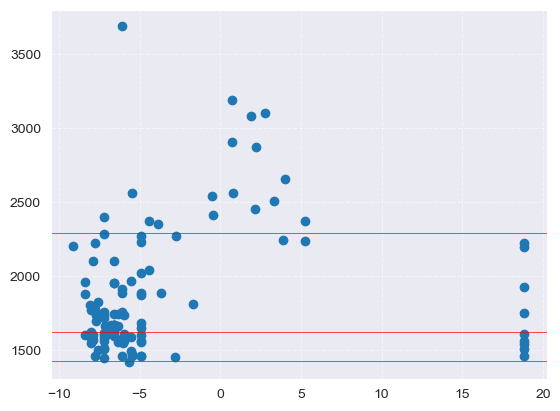

In [15]:
dt = pd.Timestamp(datetime.datetime(2023,11,29,20,0,0), tz="UTC")

theta_df = get_profile_df(dt,df,elevs,stids,temp_type="drybulb")
fig,ax = plt.subplots(1)
ax.scatter(theta_df["drybulb"],theta_df["elevation"])

level_dict = {"Ouray":1425,"Vernal":1622,"Split Mtn":2294}
ax = plot_hline_lv(ax,level_dict,c="red",lw=0.5)

# Should find way to avoid plotting anomalies - bound to within std of mean